## Naive Bayes Modeling and some EDA using: 
### - Transformer: CountVectorizer
### - Stemmed words

In [4]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Naive Bayes 
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# Other Sklearn 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score, classification_report

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# NLP imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# nltk.download()  --> Download all, and then restart jupyter lab
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
import re

### Loading Data and Splitting Data

In [5]:
# Load the data
df = pd.read_csv('../../../data/clean_data/clean_posts.csv', index_col=0)
df.head()

,subreddit,title,created_utc,selftext,title_selftext,author,media_only,permalink,text_length,clean_text_stem,clean_text_lem
0,tolkienfans,What happened to Tolkien’s Red Book?,1616977706,I was wondering if somebody could clear up my ...,what happened to tolkien s red book i was wond...,lukeskinwalker69epic,False,/r/tolkienfans/comments/mfdrms/what_happened_t...,322,happen tolkien red book wonder somebodi could ...,happened tolkien red book wondering somebody c...
1,tolkienfans,What Makes People Turn Invisible When the Put ...,1616971688,I guess this is a big question because I never...,what makes people turn invisible when the put ...,Jpmaniax26,False,/r/tolkienfans/comments/mfbzjh/what_makes_peop...,252,make peopl turn invis put one ring guess big q...,make people turn invisible put one ring guess ...
2,tolkienfans,"Theory: At some point not told in the Tale, Ar...",1616971077,This is the last dialogue between Queen Undómi...,theory at some point not told in the tale arag...,yew_eater,False,/r/tolkienfans/comments/mfbsks/theory_at_some_...,6045,theori point told tale aragorn arwen must seri...,theory point told tale aragorn arwen must seri...
3,tolkienfans,I’d like to purchase a matching set of books o...,1616969977,Can anyone help me out? Looking for matching b...,i d like to purchase a matching set of books o...,GoosePants72,False,/r/tolkienfans/comments/mfbfyj/id_like_to_purc...,302,like purchas match set book everyth lotr silma...,like purchase matching set book everything lot...
4,tolkienfans,"When Faramir ‘proposes’ to Eowyn, something we...",1616966528,After he confesses his love for her and talks ...,when faramir proposes to eowyn something weird...,PhendranaDrifter,False,/r/tolkienfans/comments/mfaae8/when_faramir_pr...,731,faramir propos eowyn someth weird happen confe...,faramir proposes eowyn something weird happens...


In [6]:
# Checks baseline
df['subreddit'].value_counts(normalize=True)
# df['subreddit'].value_counts()

tolkienfans    0.516823
harrypotter    0.483177
Name: subreddit, dtype: float64

In [7]:
df['clean_text_stem'].isna().sum()

0

In [8]:
# Set up X and y
X = df['clean_text_stem']
y = df['subreddit']

In [9]:
# Splits the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    random_state=42)

### Some EDA with Vectorized Text

In [11]:
# # Instantiate a CountVectorizer with the default hyperparameters.
# cvec = CountVectorizer(stop_words = ['would', 'like', 'know', 'think', 'could', 'first', 
#                                      'http', 'get'])

# X_train.isna().sum()

# # Fits and transfoarms the vectorizer on our corpus
# X_train = cvec.fit_transform(X_train)
# X_test = cvec.transform(X_test)

# cvec.get_feature_names()[1840:1856]

# X_train_df = pd.DataFrame(X_train.toarray(), columns=cvec.get_feature_names())
# X_test_df = pd.DataFrame(X_test.toarray(), columns=cvec.get_feature_names())
# # X_train_df
# X_test_df

# X_train_df = X_train_df.loc[:, 'aback':]
# X_test_df = X_test_df.loc[:, 'aback':]
# # X_train_df
# X_test_df

# # plot top occurring words
# X_train_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')

### Modeling Naive Bayes

In [12]:
# Baseline accuracy 
y_test.value_counts(normalize=True)

tolkienfans    0.516821
harrypotter    0.483179
Name: subreddit, dtype: float64

In [13]:
# Instantiates a pipeline 
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [14]:
# Creates the Pipe Gridsearch parameters
pipe_params = {
    'cvec__max_features':[2_000, 3_000, 4_000, 5_000],
    'cvec__min_df':[2, 3],
    'cvec__max_df':[0.90, 0.95],
    'cvec__ngram_range':[(1,1), (1,2)]
}

In [17]:
# Instantiates the GridSearchCV
gs = GridSearchCV(pipe, 
                param_grid=pipe_params,
                cv=5, 
                verbose=2, 
                n_jobs = 4)

In [18]:
# Fits GridSearch to training data
gs.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   19.3s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:  1.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=4,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=2)

#### Evaluation/results

In [19]:
# Best CV score
gs.best_score_

0.9695077729561403

In [20]:
# Prints the training and testing accuracy scores
train, test = gs.score(X_train, y_train), gs.score(X_test, y_test)
train, test

(0.9719613066031123, 0.9711942809083264)

In [21]:
# Best gridsearch parameters
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

In [22]:
# Creates the y predictions and calculates the AUC score so it can be used in model metrics table
y_preds = gs.predict(X_test)
auc = roc_auc_score(y_test, gs.predict_proba(X_test)[:,1])

In [23]:
# Creates the model metrics dataframe row to be added into final table of model metrics for presentation
results = pd.DataFrame({'Model': ['Multinomial NB'], 
                        'Transformer': ['CountVectorizer'],
                        'Stemmed/Lemmed': ['Stemmed'],
                        'Train_acc': [train],
                        'Test_acc': [test], 
                        'AUC': [auc]})
results.to_csv('../../../data/result_scores/nb_countvec_stem.csv')

In [24]:
results

,Model,Transformer,Stemmed/Lemmed,Train_acc,Test_acc,AUC
0,Multinomial NB,CountVectorizer,Stemmed,0.971961,0.971194,0.997536


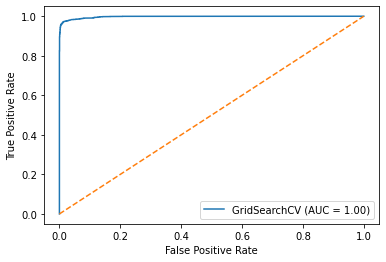

In [25]:
# plots the roc curve to visualize the auc
plot_roc_curve(gs, X_test, y_test)
plt.plot([0,1],[0,1], label='baseline', linestyle='--');

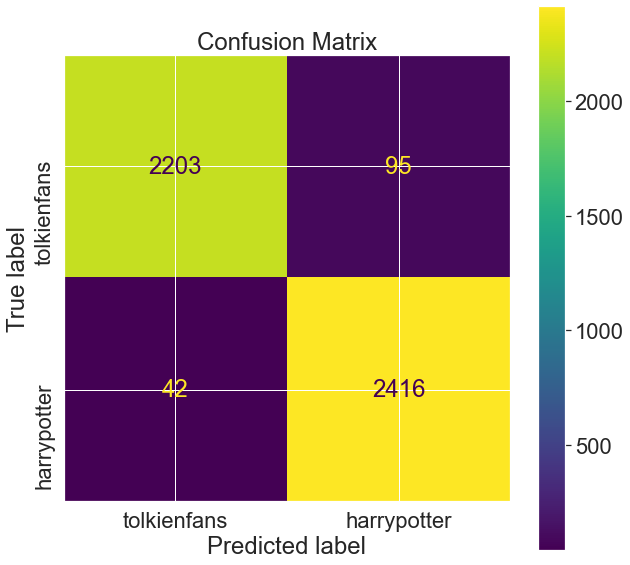

In [27]:
# Creates the confusion matrix and saves it as an image to be used in presentation
sns.set(font_scale=2.0)
cm = confusion_matrix(y_test, y_preds)
fig, ax = plt.subplots(figsize=(10, 10))
plot = ConfusionMatrixDisplay(cm).plot(ax=ax)
plot
plt.title('Confusion Matrix')
# ax.set_title('Confusion Matrix', fontdict={'size':'15'})
ax.set_xticklabels(df['subreddit'].unique());
ax.set_yticklabels(df['subreddit'].unique(), rotation=90);
# ax.set_xlabel('Predicted label', fontdict={'size':'15'})
# ax.set_ylabel('True label', fontdict={'size':'15'})

plt.savefig('../../../presentation/imgs/cm_nb_countvec_stem.jpg')

In [28]:
# Creates the coef dictionary dataframe, and prints out the 10 smallest coefficients
coefs = gs.best_estimator_.named_steps['nb'].coef_
coefs = coefs.ravel()

names = gs.best_estimator_.named_steps['cvec'].get_feature_names()

coef_dict = pd.DataFrame({'coefs': coefs,
                      'features': pd.Series(names)})
coef_dict.nsmallest(10, columns=['coefs'])

,coefs,features
29,-13.065787,1st place
59,-13.065787,3rd place
93,-13.065787,accio
107,-13.065787,action tv
159,-13.065787,alan rickman
161,-13.065787,albu
162,-13.065787,albu dumbledor
224,-13.065787,amp auto
240,-13.065787,andromeda
250,-13.065787,animagu


In [29]:
# prints out the 10 largest coefficients
coef_dict.nlargest(10, columns=['coefs'])

,coefs,features
4427,-4.518841,tolkien
4877,-4.677564,would
3670,-4.745826,ring
3485,-4.855662,read
2514,-4.923723,like
3056,-4.989271,one
551,-5.117048,book
2394,-5.118815,know
3769,-5.186874,sauron
4325,-5.290931,think
